# **1. Import Libraries**

In [1]:
!pip install scikit-image tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision import models
from torchvision.utils import save_image
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers.schedulers import DDPMScheduler
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
import random
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **2. Import Dataset and Preprocessing**

In [2]:
# Feature extraction from ResNet - 101

project_root = "image_reconstruction_project"
os.makedirs(f"{project_root}/features", exist_ok=True)
os.makedirs(f"{project_root}/images", exist_ok=True)


# Load Imagenette (ImageNet Subset)
# Standard ImageNet preprocessing: Resize to 256, then CenterCrop to 224.
# This preserves aspect ratio better than simple resizing.
transform_norm = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

transform_plain = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor()
])

print("Downloading Imagenette (ImageNet subset)")


dataset = torchvision.datasets.Imagenette(
    root='./data',
    split='train',
    size='320px',
    download=True,
    transform=transform_norm
)

dataset_plain = torchvision.datasets.Imagenette(
    root='./data',
    split='train',
    size='320px',
    download=True,
    transform=transform_plain
)



100%|██████████| 342M/342M [00:20<00:00, 16.9MB/s]


We download Imagenette dataset from torchvision have two dataset. First one is the dataset which goes through transform to preprocess the data and normalize it for feature extraction. Second one is used for image comparison with reconstructed image.

# **Paired Dataset**

In [3]:
# Align indices for pairs
indices = list(range(len(dataset)))
# indices = indices[:2000]

class PairedDataset(torch.utils.data.Dataset):
    def __init__(self, input_ds, target_ds, indices):
        self.input_ds = input_ds
        self.target_ds = target_ds
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        return self.input_ds[real_idx][0], self.target_ds[real_idx][0]

train_loader = DataLoader(
    PairedDataset(dataset, dataset_plain, indices),
    batch_size=16,
    shuffle=True,
    num_workers=2
)

Paired dataset is used for supervised learning and calculating metrics such as PSNR, SSIM and Loss function as generator need to know what the correct image looks like.

In [4]:
# For reproducibility
random.seed(42)
torch.manual_seed(42)

# Random subset - ensures diverse class distribution
save_limit = 5000
random_indices = random.sample(range(len(dataset)), min(save_limit, len(dataset)))
random_subset = torch.utils.data.Subset(dataset, random_indices)
random_subset_plain = torch.utils.data.Subset(dataset_plain, random_indices)

dataloader = torch.utils.data.DataLoader(random_subset, batch_size=32, shuffle=False)
dataloader_plain = torch.utils.data.DataLoader(random_subset_plain, batch_size=32, shuffle=False)


print(f"Dataset loaded. Classes: {len(dataset.classes)}")

Dataset loaded. Classes: 10


# **3. Feature Extraction Using ResNet - 101**

In [5]:
model = models.resnet101(weights="IMAGENET1K_V2").to(device)
model.eval()

# Feature cache
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach().cpu()
    return hook

# Register hooks
model.layer1.register_forward_hook(get_features('layer1'))
model.layer2.register_forward_hook(get_features('layer2'))
model.layer3.register_forward_hook(get_features('layer3'))
model.layer4.register_forward_hook(get_features('layer4'))
model.avgpool.register_forward_hook(get_features('avgpool'))

print("Extracting features")

all_features = {
    'layer1': [],
    'layer2': [],
    'layer3': [],
    'layer4': [],
    'avgpool': []
}

save_limit = 5000
count = 0
plain_iter = iter(dataloader_plain)

for images, _ in tqdm(dataloader):
    try:
        plain_images, _ = next(plain_iter)
    except StopIteration:
        break

    images = images.to(device)

    with torch.no_grad():
        _ = model(images)

    # Retrieve hooked features
    f1 = features['layer1']
    f2 = features['layer2']
    f3 = features['layer3']
    f4 = features['layer4']
    fpool = features['avgpool']

    all_features['layer1'].append(f1.cpu().numpy().astype(np.float16))
    all_features['layer2'].append(f2.cpu().numpy().astype(np.float16))
    all_features['layer3'].append(f3.cpu().numpy().astype(np.float16))
    all_features['layer4'].append(f4.cpu().numpy().astype(np.float16))
    all_features['avgpool'].append(fpool.cpu().numpy().astype(np.float16))


    for i in range(images.size(0)):
        img_id = count + i
        save_image(plain_images[i], f"{project_root}/images/{img_id:05d}.png")

    count += images.size(0)
    if count >= save_limit:
        break

# After collecting all features, concatenate them and save
for key in all_features:
    all_features[key] = np.concatenate(all_features[key], axis=0)

np.savez_compressed(
    f"{project_root}/all_features.npz",
    layer1=all_features['layer1'],
    layer2=all_features['layer2'],
    layer3=all_features['layer3'],
    layer4=all_features['layer4'],
    avgpool=all_features['avgpool']
)

print(f"Saved {count} samples.")

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


100%|██████████| 171M/171M [00:00<00:00, 225MB/s]


Extracting features


 99%|█████████▉| 156/157 [03:22<00:01,  1.30s/it]


Saved 5000 samples.


Feature are extracted using ResNet - 101 with weights from IMAGENET1K_V2 and model.eval() is done we are only extracting features and not training it. We use hook to extract 5 layers which include 1, 2, 3, 4 and avgpool. the features are saved in all_features.npz

# **4. Visualize Image and Features**

In [6]:
def visualize_image_and_features(root, img_id, num_channels=6, features_data=None):
    """
    Visualize image and its feature maps.

    Args:
        root: Project root directory
        img_id: Image ID to visualize
        num_channels: Number of feature channels to display per layer
    """
    # Load original image
    img = Image.open(f"{root}/images/{img_id:05d}.png").convert("RGB")

    # Load features
    if features_data is None:
        features_data = np.load(f"{root}/all_features.npz")

    # Get features for this specific image
    data = {
        "layer1": torch.from_numpy(features_data['layer1'][img_id]),
        "layer2": torch.from_numpy(features_data['layer2'][img_id]),
        "layer3": torch.from_numpy(features_data['layer3'][img_id]),
        "layer4": torch.from_numpy(features_data['layer4'][img_id]),
    }

    layers = ["layer1", "layer2", "layer3", "layer4"]

    # Display original image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Original Image (ID: {img_id})")
    plt.axis("off")
    plt.show()

    # Display feature maps for each layer
    for layer in layers:
        feat = data[layer]
        C = feat.shape[0]
        idxs = np.linspace(0, C-1, num_channels, dtype=int)

        fig, axes = plt.subplots(1, num_channels, figsize=(3*num_channels, 3))
        fig.suptitle(f"{layer} Feature Maps (shape: {feat.shape})", fontsize=16)

        for i, c in enumerate(idxs):
            fmap = feat[c].cpu().numpy()
            fmap_norm = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)
            axes[i].imshow(fmap_norm, cmap="inferno")
            axes[i].set_title(f"Ch {c}")
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()


the extracted features are visualized to see what feature are extracted in different layers. this helps in reconstructing the image.

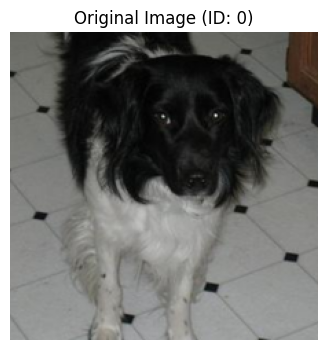

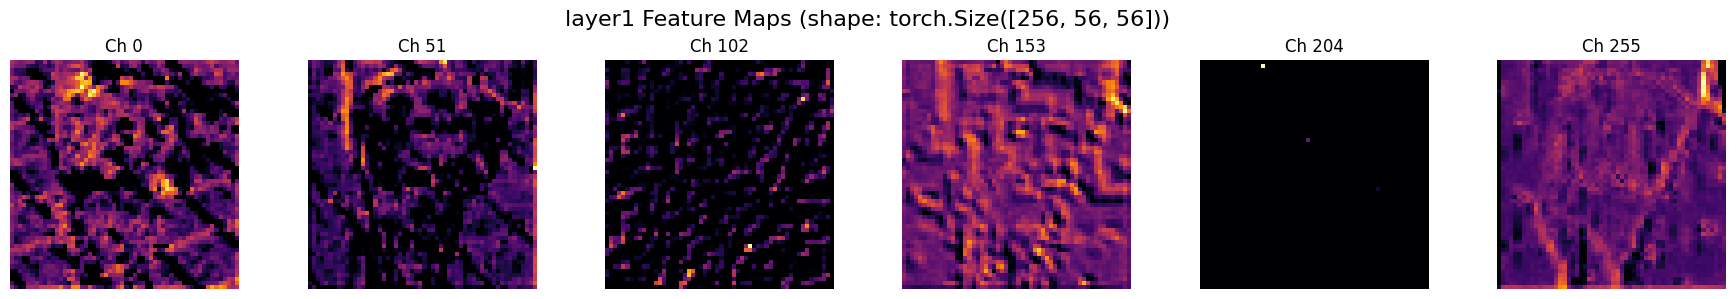

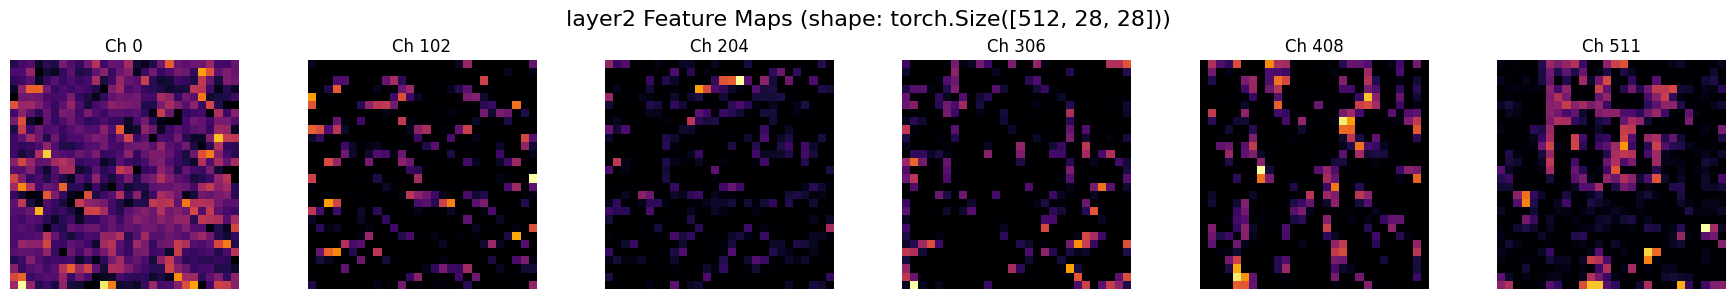

/tmp/ipython-input-2826275398.py:45: RuntimeWarning: invalid value encountered in divide
  fmap_norm = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)


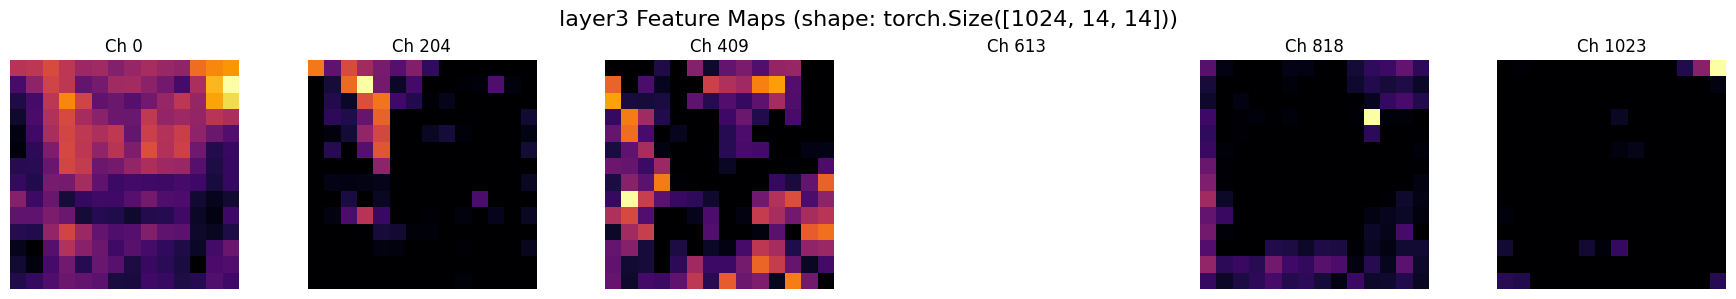

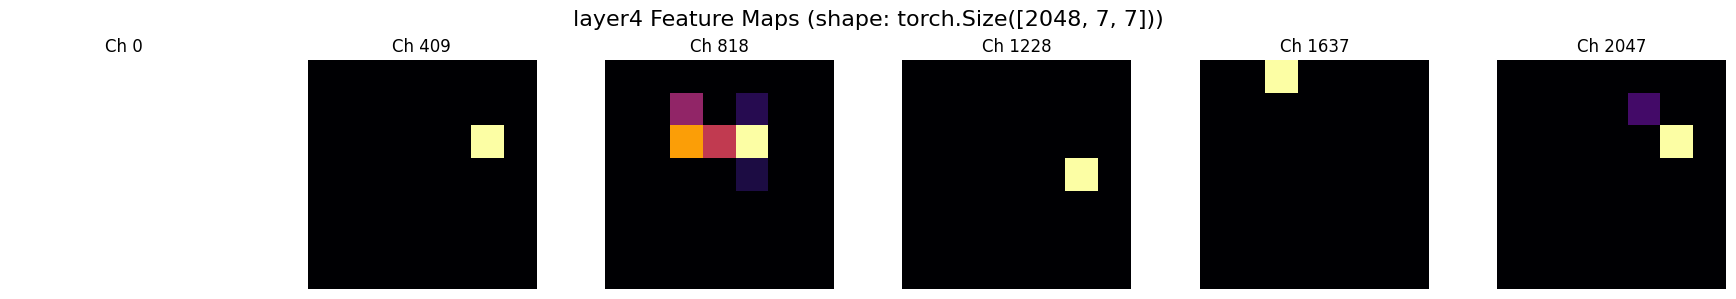

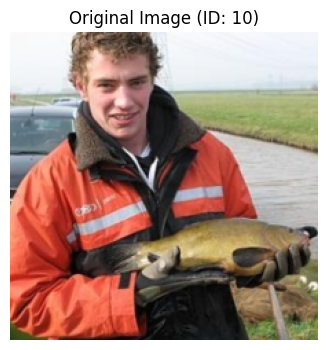

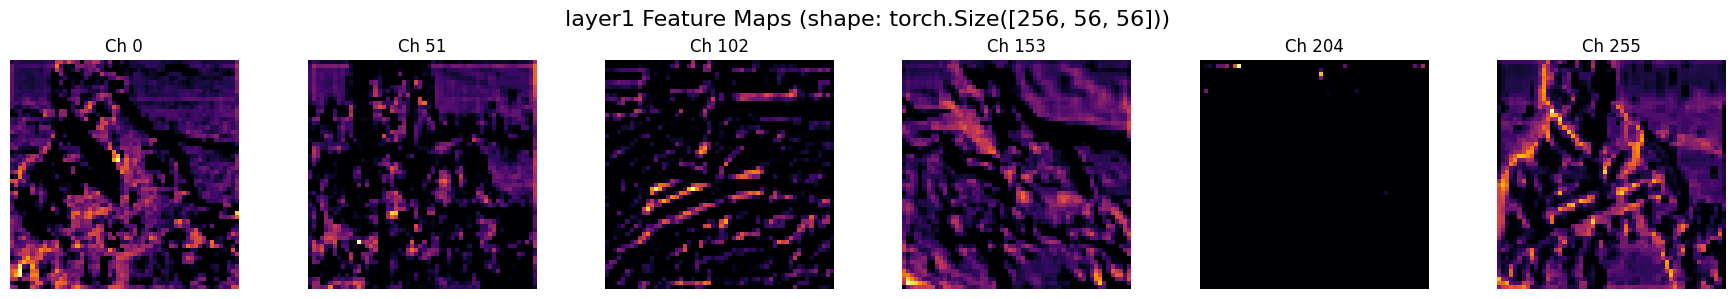

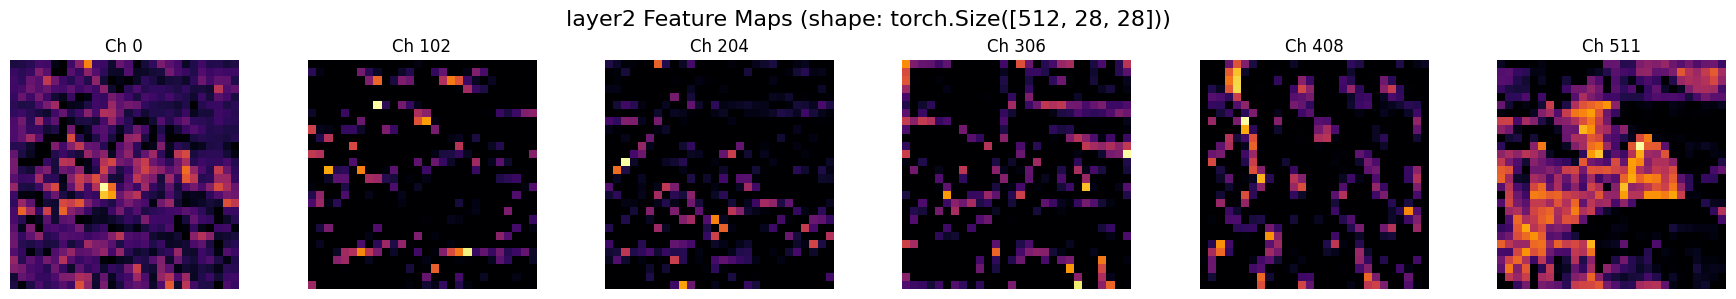

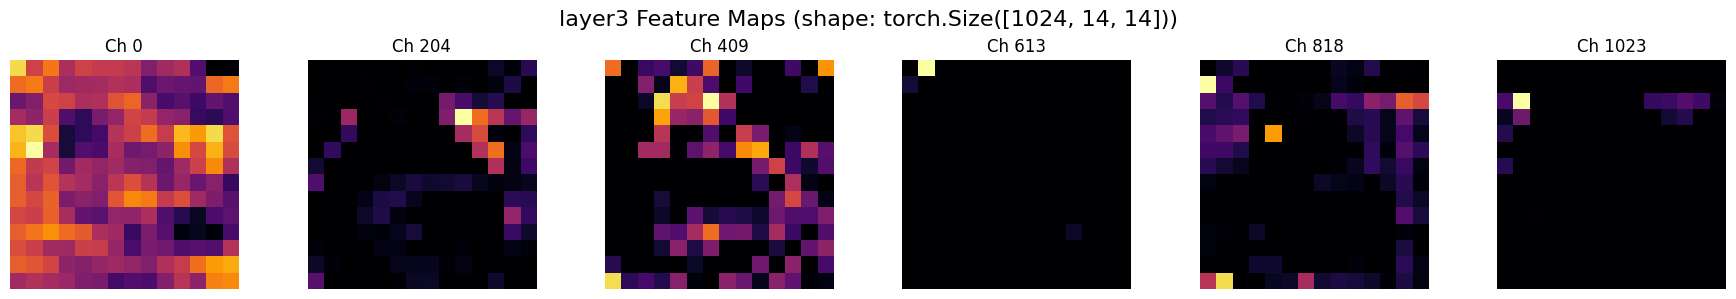

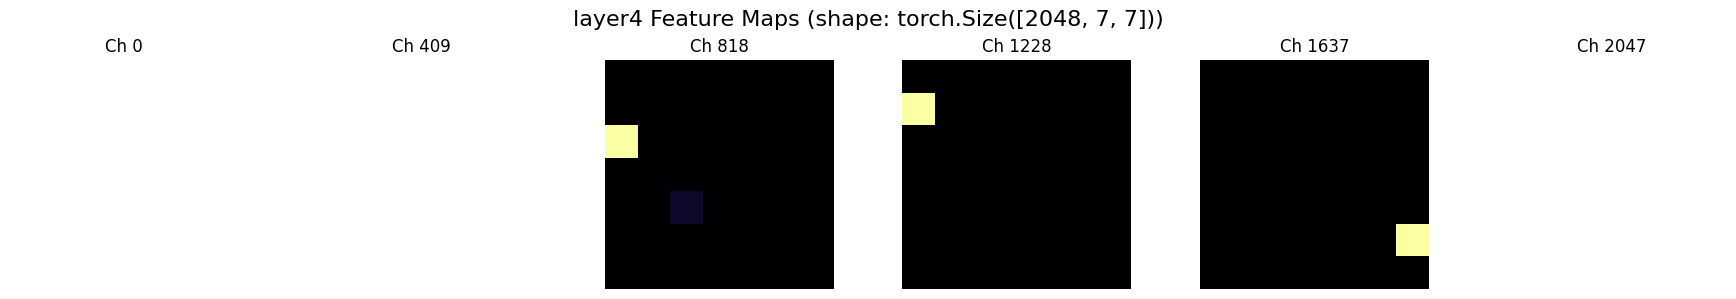

In [7]:
features_data = np.load("image_reconstruction_project/all_features.npz")

for img_id in [0, 10]:
    visualize_image_and_features(
        root="image_reconstruction_project",
        img_id=img_id,
        num_channels=6,
        features_data=features_data
    )

# Close the file
features_data.close()

We plot images in different layer to understand which layer extract which features like layer 1 extract edges.

# **Directories and Hyperparameters**

In [8]:
project_root = "/content/image_reconstruction_project"
FEATURE_FILE = f"{project_root}/all_features.npz"
IMAGE_DIR = f"{project_root}/images"

# Create output directory for GAN results
out_dir = f"{project_root}/gan_outputs"
os.makedirs(out_dir, exist_ok=True)

print("Feature file:", FEATURE_FILE)
print("Image directory:", IMAGE_DIR)
print("Output directory:", out_dir)

# Hyperparameters
batch_size = 32
epochs = 30
lr = 2e-4
beta1, beta2 = 0.5, 0.999
img_size = 224
img_channels = 3
noise_dim = 100

# Feature map shapes from your ResNet101 extraction:
# layer1: (N, 256, 56, 56)
# layer2: (N, 512, 28, 28)
# layer3: (N, 1024, 14, 14)
# layer4: (N, 2048, 7, 7)
# avgpool: (N, 2048, 1, 1)

Feature file: /content/image_reconstruction_project/all_features.npz
Image directory: /content/image_reconstruction_project/images
Output directory: /content/image_reconstruction_project/gan_outputs


In [9]:
class FeatureDataset(Dataset):
    def __init__(self, feature_npz, img_folder):
        data = np.load(feature_npz)

        self.layer1 = data["layer1"]    # (N, 256, 56, 56)
        self.n = self.layer1.shape[0]
        self.img_folder = img_folder

        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor()
        ])

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        feat = torch.tensor(self.layer1[idx], dtype=torch.float32)

        img_path = f"{self.img_folder}/{idx:05d}.png"
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return feat, img

This class is used for calling the extracted features dataset to pass throught GAN model.

# **5. Generator**

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Project 256 channels → 128
        self.in_proj = nn.Sequential(
            nn.Conv2d(256, 128, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )

        # Decoder to 224×224
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 4, 2, 1),  # 56 → 112
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 112 → 224
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(True),

            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.in_proj(x)
        x = self.decoder(x)
        return x

Generator creates new data sample with the help of features and noise and make a fake data. this data is passed to discriminator. the role of generator is to minimize the chance that discriminator correctly identifies the data from generator as fake.

# **6. Discriminator**

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),   # 224→112
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1), # 112→56
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),# 56→28
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, 2, 1),# 28→14
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, 3, padding=1)
        )

    def forward(self, img):
        return self.model(img)

Discriminator is the detective where it differentiate data as real or fake. it gets its input from the generator which gives both the real and fake data. discriminator give a probability score if the input is real or fake. its goal is to maximize the accuracy.

In [12]:
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCEWithLogitsLoss()

opt_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

dataset = FeatureDataset(FEATURE_FILE, IMAGE_DIR)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Both Generator and discriminator are running simentanously. generator learns from the gradient provided by the discriminator.

# Calculate PSNR and SSIM

In [13]:
def batch_psnr_ssim(real, fake):
    real = real.permute(0, 2, 3, 1).detach().cpu().numpy()
    fake = fake.permute(0, 2, 3, 1).detach().cpu().numpy()

    psnr_vals = []
    ssim_vals = []

    for r, f in zip(real, fake):
        psnr_vals.append(psnr(r, f, data_range=1.0))
        ssim_vals.append(ssim(r, f, channel_axis=2, data_range=1.0))

    return np.mean(psnr_vals), np.mean(ssim_vals)


# Split the Dataset into Training and Validation

In [14]:
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

print("Train samples:", train_size)
print("Val samples:", val_size)

Train samples: 4000
Val samples: 1000


# **7. Training Loop**

In [16]:
train_G, train_D = [], []
val_G, val_D = [], []

train_PSNR, train_SSIM = [], []
val_PSNR, val_SSIM = [], []

for epoch in range(epochs):

    G.train()
    D.train()

    g_loss_epoch = 0
    d_loss_epoch = 0
    p_epoch = 0
    s_epoch = 0

    # TRAINING
    for feat1, real in tqdm(train_loader):

        feat1 = feat1.to(device)
        real = real.to(device)

        b = real.size(0)
        valid = torch.ones(b, 1, 14, 14).to(device)
        fake = torch.zeros(b, 1, 14, 14).to(device)

        # Train D
        opt_D.zero_grad()
        gen_imgs = G(feat1).detach()

        real_loss = criterion(D(real), valid)
        fake_loss = criterion(D(gen_imgs), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        opt_D.step()

        # Train G
        opt_G.zero_grad()
        gen_imgs = G(feat1)
        g_loss = criterion(D(gen_imgs), valid)
        g_loss.backward()
        opt_G.step()

        # PSNR + SSIM
        p, s = batch_psnr_ssim(real, gen_imgs)

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()
        p_epoch += p
        s_epoch += s

    train_G.append(g_loss_epoch / len(train_loader))
    train_D.append(d_loss_epoch / len(train_loader))
    train_PSNR.append(p_epoch / len(train_loader))
    train_SSIM.append(s_epoch / len(train_loader))

    # VALIDATION
    G.eval()
    D.eval()

    vg = vd = vp = vs = 0

    with torch.no_grad():
        for feat1, real in val_loader:

            feat1 = feat1.to(device)
            real = real.to(device)

            b = real.size(0)
            valid = torch.ones(b, 1, 14, 14).to(device)
            fake = torch.zeros(b, 1, 14, 14).to(device)

            gen_imgs = G(feat1)

            g_loss = criterion(D(gen_imgs), valid)
            d_loss = criterion(D(real), valid) + criterion(D(gen_imgs), fake)

            p, s = batch_psnr_ssim(real, gen_imgs)

            vg += g_loss.item()
            vd += d_loss.item()
            vp += p
            vs += s

    val_G.append(vg / len(val_loader))
    val_D.append(vd / len(val_loader))
    val_PSNR.append(vp / len(val_loader))
    val_SSIM.append(vs / len(val_loader))

    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"| Train G: {train_G[-1]:.4f}, D: {train_D[-1]:.4f}, PSNR: {train_PSNR[-1]:.2f}, SSIM: {train_SSIM[-1]:.3f} "
        f"| Val G: {val_G[-1]:.4f}, D: {val_D[-1]:.4f}, PSNR: {val_PSNR[-1]:.2f}, SSIM: {val_SSIM[-1]:.3f}"
    )

100%|██████████| 125/125 [00:55<00:00,  2.24it/s]


Epoch [1/30] | Train G: 0.9875, D: 1.2834, PSNR: 10.47, SSIM: 0.124 | Val G: 1.0005, D: 1.2551, PSNR: 12.03, SSIM: 0.181


100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Epoch [2/30] | Train G: 0.8777, D: 1.3393, PSNR: 12.78, SSIM: 0.212 | Val G: 0.8253, D: 1.3171, PSNR: 13.57, SSIM: 0.252


100%|██████████| 125/125 [00:54<00:00,  2.27it/s]


Epoch [3/30] | Train G: 0.7870, D: 1.3651, PSNR: 14.45, SSIM: 0.280 | Val G: 0.7521, D: 1.3813, PSNR: 15.33, SSIM: 0.310


100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Epoch [4/30] | Train G: 0.7747, D: 1.3696, PSNR: 14.85, SSIM: 0.291 | Val G: 0.6926, D: 1.3773, PSNR: 15.65, SSIM: 0.303


100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Epoch [5/30] | Train G: 0.7977, D: 1.3711, PSNR: 15.00, SSIM: 0.291 | Val G: 0.7333, D: 1.3879, PSNR: 16.30, SSIM: 0.323


100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Epoch [6/30] | Train G: 0.7754, D: 1.3724, PSNR: 15.62, SSIM: 0.318 | Val G: 0.6807, D: 1.4182, PSNR: 15.67, SSIM: 0.307


100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Epoch [7/30] | Train G: 0.8036, D: 1.3662, PSNR: 15.73, SSIM: 0.316 | Val G: 0.7494, D: 1.3860, PSNR: 15.81, SSIM: 0.304


100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Epoch [8/30] | Train G: 0.8167, D: 1.3656, PSNR: 15.12, SSIM: 0.307 | Val G: 0.8856, D: 1.4071, PSNR: 15.73, SSIM: 0.287


100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Epoch [9/30] | Train G: 0.8276, D: 1.3592, PSNR: 15.32, SSIM: 0.325 | Val G: 0.8984, D: 1.3105, PSNR: 16.15, SSIM: 0.362


100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Epoch [10/30] | Train G: 0.8594, D: 1.3421, PSNR: 15.37, SSIM: 0.298 | Val G: 0.7924, D: 1.4201, PSNR: 14.70, SSIM: 0.298


100%|██████████| 125/125 [00:54<00:00,  2.27it/s]


Epoch [11/30] | Train G: 0.9018, D: 1.3334, PSNR: 15.57, SSIM: 0.312 | Val G: 0.8300, D: 1.3643, PSNR: 15.75, SSIM: 0.339


100%|██████████| 125/125 [00:54<00:00,  2.27it/s]


Epoch [12/30] | Train G: 0.9940, D: 1.2926, PSNR: 14.85, SSIM: 0.267 | Val G: 1.1211, D: 1.2362, PSNR: 14.84, SSIM: 0.231


100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Epoch [13/30] | Train G: 1.0566, D: 1.2670, PSNR: 15.12, SSIM: 0.327 | Val G: 1.3427, D: 1.6436, PSNR: 14.00, SSIM: 0.358


100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Epoch [14/30] | Train G: 1.0318, D: 1.2550, PSNR: 15.90, SSIM: 0.387 | Val G: 0.9685, D: 1.3213, PSNR: 16.42, SSIM: 0.426


100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Epoch [15/30] | Train G: 0.9635, D: 1.2863, PSNR: 16.39, SSIM: 0.433 | Val G: 0.7105, D: 1.3253, PSNR: 16.63, SSIM: 0.437


100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Epoch [16/30] | Train G: 0.9473, D: 1.2725, PSNR: 16.70, SSIM: 0.449 | Val G: 0.6651, D: 1.3239, PSNR: 17.61, SSIM: 0.466


100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Epoch [17/30] | Train G: 0.9642, D: 1.2852, PSNR: 16.71, SSIM: 0.460 | Val G: 0.5771, D: 1.4444, PSNR: 16.39, SSIM: 0.487


100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Epoch [18/30] | Train G: 0.9384, D: 1.3045, PSNR: 17.09, SSIM: 0.494 | Val G: 0.7852, D: 1.3267, PSNR: 17.84, SSIM: 0.488


100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Epoch [19/30] | Train G: 0.9437, D: 1.2637, PSNR: 17.36, SSIM: 0.498 | Val G: 0.8811, D: 1.4045, PSNR: 18.06, SSIM: 0.508


100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Epoch [20/30] | Train G: 0.9381, D: 1.2875, PSNR: 17.43, SSIM: 0.517 | Val G: 0.7734, D: 1.3770, PSNR: 17.55, SSIM: 0.513


100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Epoch [21/30] | Train G: 0.9553, D: 1.2721, PSNR: 17.39, SSIM: 0.515 | Val G: 0.7164, D: 1.3974, PSNR: 17.89, SSIM: 0.537


100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Epoch [22/30] | Train G: 0.9581, D: 1.2611, PSNR: 17.69, SSIM: 0.531 | Val G: 0.9408, D: 1.3568, PSNR: 18.31, SSIM: 0.541


100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Epoch [23/30] | Train G: 1.0034, D: 1.2456, PSNR: 17.73, SSIM: 0.532 | Val G: 0.7008, D: 1.3480, PSNR: 17.33, SSIM: 0.535


100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Epoch [24/30] | Train G: 0.9825, D: 1.2341, PSNR: 17.65, SSIM: 0.530 | Val G: 0.8644, D: 1.3448, PSNR: 17.59, SSIM: 0.543


100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Epoch [25/30] | Train G: 1.0005, D: 1.2420, PSNR: 18.01, SSIM: 0.544 | Val G: 0.9614, D: 1.3470, PSNR: 19.47, SSIM: 0.567


100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Epoch [26/30] | Train G: 0.9167, D: 1.3162, PSNR: 18.83, SSIM: 0.570 | Val G: 0.6753, D: 1.3596, PSNR: 19.51, SSIM: 0.592


100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Epoch [27/30] | Train G: 0.9266, D: 1.2894, PSNR: 19.21, SSIM: 0.583 | Val G: 0.7391, D: 1.3226, PSNR: 19.74, SSIM: 0.603


100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Epoch [28/30] | Train G: 0.9277, D: 1.3053, PSNR: 19.25, SSIM: 0.594 | Val G: 0.7776, D: 1.3518, PSNR: 20.25, SSIM: 0.598


100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Epoch [29/30] | Train G: 0.8968, D: 1.2940, PSNR: 19.77, SSIM: 0.606 | Val G: 0.6744, D: 1.3731, PSNR: 21.06, SSIM: 0.622


100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Epoch [30/30] | Train G: 0.9226, D: 1.3099, PSNR: 20.03, SSIM: 0.619 | Val G: 0.7426, D: 1.3713, PSNR: 20.21, SSIM: 0.640


# **Training and Validation Loss**

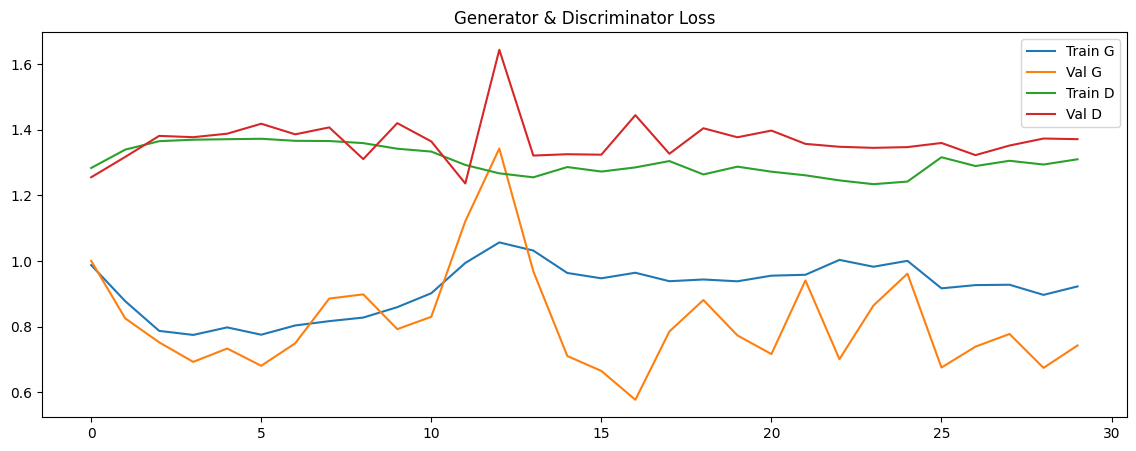

In [17]:
plt.figure(figsize=(14,5))
plt.plot(train_G, label="Train G")
plt.plot(val_G, label="Val G")
plt.plot(train_D, label="Train D")
plt.plot(val_D, label="Val D")
plt.legend()
plt.title("Generator & Discriminator Loss")
plt.show()

# **Original Vs Reconstructed Image**

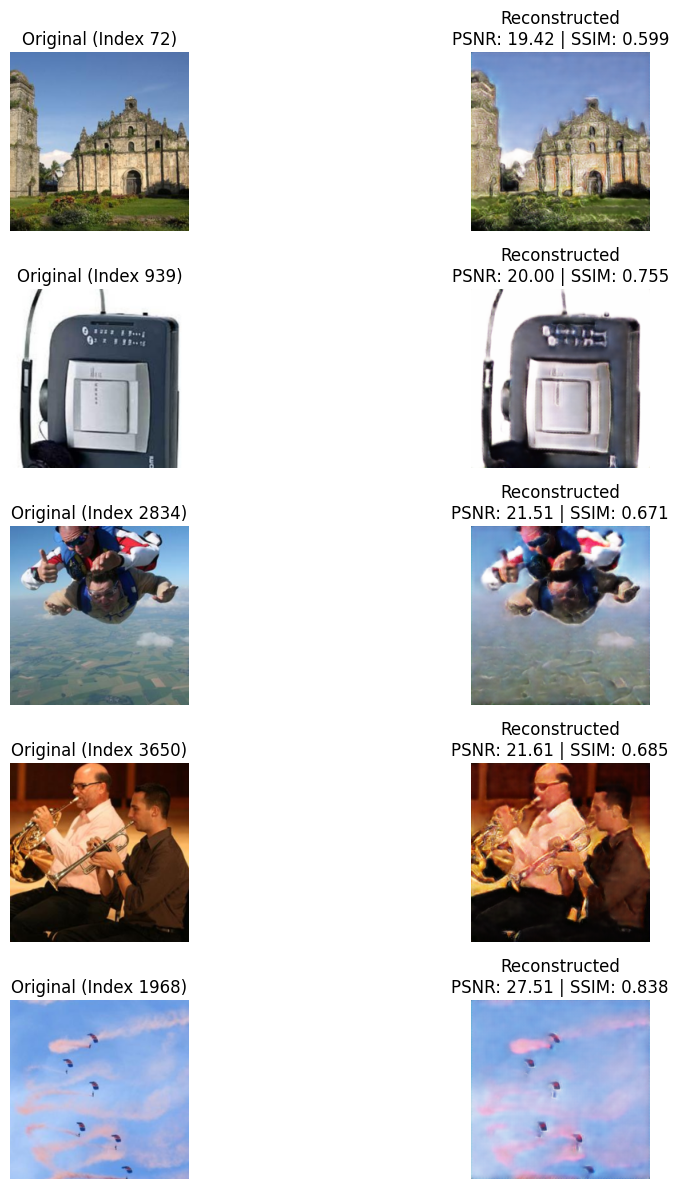

In [20]:
indices = random.sample(range(len(dataset)), 5)
plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    feat1, real = dataset[idx]

    feat1 = feat1.unsqueeze(0).to(device)
    real_img = real.permute(1, 2, 0).detach().cpu().numpy()

    with torch.no_grad():
        recon = G(feat1).cpu()

    recon_img = recon[0].permute(1, 2, 0).detach().numpy()

    # Compute metrics
    p = psnr(real_img, recon_img, data_range=1.0)
    s = ssim(real_img, recon_img, channel_axis=2, data_range=1.0)

    # ---- Plot Original ----
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(real_img)
    plt.title(f"Original (Index {idx})")
    plt.axis("off")

    # ---- Plot Reconstructed ----
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(recon_img)
    plt.title(f"Reconstructed\nPSNR: {p:.2f} | SSIM: {s:.3f}")
    plt.axis("off")

plt.tight_layout()
plt.show()
